# Introduction

**Context**

I participated in this challenge as part of the evaluation of the Machine Learning module during my Post Master's Degree in Big Data (Télécom Paris, 2021-2022).
We were graded on the basis of the individual notebook and our rank among the others 60 students competing. The following work allowed me to reach the 3rd position.

**Presentation**

How does modern face recognition work?

In the past few years, Face Recognition (FR) systems have reached extremely high levels of performance, paving the way to a broader range of applications, where the reliability levels were previously prohibitive to consider automation. This is mainly due to the adoption of deep learning techniques in computer vision. The most adopted paradigm consists in training a network $f: \mathcal{X} \rightarrow \mathbb{R}^{d}$ which, from a given image $i m \in \mathcal{X}$, extracts a feature vector $z \in \mathbb{R}^{d}$ which synthetizes the relevant caracteristics of $i m$. The recognition phase then consists, from two images $i m_{1}, i m_{2}$, to predict wether they correspond to the same identity or not. This is done from the extracted features $z_{1}, z_{2}$.


**Objective** 

In this data challenge, we are asked to train a machine learning model which, from a vector $\left[z_{1}, z_{2}\right]$ made of the concatenation of two templates $z_{1}$ and $z_{2}$, predict wether or not these two images correspond to the same identity.

# Imports

In [ ]:
# Tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_curve, confusion_matrix, mean_squared_error

# Classifiers
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

# Must have
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

Versions :

In [6]:
!pip freeze

asttokens==2.0.5
backcall==0.2.0
catboost==1.0.4
colorama==0.4.4
cycler==0.11.0
debugpy==1.5.1
decorator==5.1.1
entrypoints==0.4
executing==0.8.2
fonttools==4.29.1
graphviz==0.19.1
ipykernel==6.9.1
ipython==8.1.0
jedi==0.18.1
joblib==1.1.0
jupyter-client==7.1.2
jupyter-core==4.9.2
kiwisolver==1.3.2
lightgbm==3.3.2
matplotlib==3.5.1
matplotlib-inline==0.1.3
nest-asyncio==1.5.4
numpy==1.22.2
packaging==21.3
pandas==1.4.1
parso==0.8.3
pickleshare==0.7.5
Pillow==9.0.1
plotly==5.6.0
prompt-toolkit==3.0.28
pure-eval==0.2.2
Pygments==2.11.2
pyparsing==3.0.7
python-dateutil==2.8.2
pytz==2021.3
pywin32==303
pyzmq==22.3.0
scikit-learn==1.0.2
scipy==1.8.0
seaborn==0.11.2
six==1.16.0
sklearn==0.0
stack-data==0.2.0
tenacity==8.0.1
threadpoolctl==3.1.0
torch==1.10.2
tornado==6.1
traitlets==5.1.1
typing_extensions==4.1.1
wcwidth==0.2.5
xgboost==1.5.2


# Tools

In [2]:
def extract_labels(txt_file):
    """
    This function is used to retrieve the .npy train and test sets
    """
    with open(txt_file) as file:
        lines = file.readlines()
    y = []
    for elem in lines:
        label = int(elem[0])
        y.append(label)
    y = np.array(y)
    return y

def compute_score(y_valid,y_pred):
    """
    This function computes the score of the prediction
    """
    CM = confusion_matrix(y_valid, y_pred)
    TN, TP = CM[0, 0], CM[1, 1]
    FP, FN = CM[0, 1], CM[1, 0]
    FPR = FP / (FP + TN)
    FNR = FN / (FN + TP)
    return 1-(FPR+FNR)

def dict2list(dic):
    """
    This function turns a dictionnary into a list
    """
    l=[]
    for key,value in dic.items():
        l.append(f"{key}: {value}")
    return l

In [3]:
class Classifier():
    """
    This class gathers basic functions needed for classification tasks : fit, predict, evaluate, cross-validate, saving,printing results, plotting
    """
    # instantiate
    def __init__(self, name, model):
        self.name=name
        self.model = model
        self.y_pred = None
        self.y_true = None
        self.rmse = None
        self.cross_val = None
        self.FPR = None
        self.FNR = None
        self.X_sample_test = None

    # fit the data into the model
    def fit(self,X,y):
        self.model.fit(X,y)
    
    # pedict the labels
    def predict(self,X_test):
        return self.model.predict(X_test)

    # save the predicted labels as .txt to submit on the platform
    def save(self,sc,y_pred_submit):
        np.savetxt(f'results/y_{self.name}_{sc:.6f}.txt', y_pred_submit, fmt='%i' , delimiter=',')
        np.savetxt(f'results/y_{self.name}_{sc:.6f}_param.txt',dict2list(self.model.get_params()), fmt="%s")

    # compute the score of the prediction
    def score(self,y_test,y_pred):
        CM = confusion_matrix(y_test, y_pred)
        TN, TP, FP, FN = CM[0, 0], CM[1, 1], CM[0, 1], CM[1, 0]
        self.FPR = FP / (FP + TN)
        self.FNR = FN / (FN + TP)
        self.score = 1-(self.FPR + self.FNR)
        self.rmse = mean_squared_error(y_test, y_pred)**.5
        return self.score

    # cross validate the model
    def cross_validate(self,X,y,cv=5):
        self.cross_val = cross_val_score(self.model, X, y, cv=cv, scoring=make_scorer(compute_score, greater_is_better=True))
        return self.cross_val

    # ploting the results
    def plot_results(self,plots=3):
        plt.figure(figsize=(17 if plots==3 else 12,4))

        # plot the scores
        plt.subplot(101+plots*10)
        x_ticks = range(0,self.cross_val.shape[0])
        # - score
        plt.hlines(self.score,colors='darkblue', xmin=min(x_ticks), xmax=max(x_ticks), label = 'classifier score')
        plt.text(max(x_ticks)+(0.25 if plots==3 else 0.08), self.score, f"{self.score:.4f}", ha='left', va='center',color='darkblue')
        # - cross validation
        plt.plot(self.cross_val, label='cross validation scores', color='grey')
        plt.hlines(np.mean(self.cross_val)+np.std(self.cross_val),colors='grey',linestyles='--', xmin=min(x_ticks), xmax=max(x_ticks), label='cross validation std')
        plt.hlines(np.mean(self.cross_val)-np.std(self.cross_val),colors='grey',linestyles='--', xmin=min(x_ticks), xmax=max(x_ticks))
        plt.title('Score'); plt.xlabel('Fold'); plt.ylabel('Scores'); plt.ylim(0.58,max([self.score,0.63])); plt.xticks(x_ticks); plt.legend(loc="lower right")

        # Confusion matrix
        plt.subplot(102+plots*10)
        CM = confusion_matrix(self.y_true, self.y_pred)
        sns.heatmap(CM, annot=True,cbar=False, fmt='g',cmap="YlGnBu")
        plt.title('Confusion matrix'); plt.xlabel('True labels'); plt.ylabel('Predicted labels')

        # ROC curve
         
        if plots==3:
            plt.subplot(103+plots*10)   
            y_prob = self.model.predict_proba(self.X_sample_test)[:, 1]
            fpr, tpr, thresholds = roc_curve(self.y_true, y_prob, pos_label=1)
            idx = np.argmin(fpr + (1-tpr))
            plt.plot(fpr, 1-tpr, label='RF'); plt.plot(fpr[idx], (1-tpr)[idx], '+', color='k')
            plt.title('ROC curve'); plt.xlabel('FPR'); plt.ylabel('FNR'); plt.grid()


        plt.subplots_adjust(wspace=0.4, hspace=.5)
        plt.suptitle(self.name,fontsize=17, y=1.1)
    
    def results(self):
        print('='*133)
        print(' '*50 + f"{self.name} results")
        print('='*133)
        print(f"Score : {self.score:.7f}")
        print(f"RMSE  : {self.rmse:.7f}")
        print(f"FPR   : {self.FPR:.5%}")
        print(f"FPR   : {self.FNR:.5%}")
        print('='*133)

    # sequential execution of above functions
    def classify_save_and_score(self,X,y,X_test,X_sample_train,y_sample_train, X_sample_test, y_sample_test,cross_validation=0,scoring = True):
        self.X_sample_test=X_sample_test

        if scoring:
            self.fit(X_sample_train,y_sample_train)
            self.y_pred = self.predict(X_sample_test)
            sc = self.score(y_sample_test,self.y_pred)

            self.y_true = y_sample_test
        else:
            sc = 0
        
        self.fit(X,y)
        y_pred_submit = self.predict(X_test)
        self.save(sc,y_pred_submit)

        if cross_validation !=0: 
            self.cross_validate(X,y,cross_validation)
        

# Data exploration and preprocessing

#### The dataset and labels

First, we retrieve the data.

In [5]:
# Train and test data
X_np, y_np, X_test_np = np.load("train_data.npy"), extract_labels("train_labels.txt"), np.load("test_data.npy")

n_features = X_np.shape[1]
n_data = X_np.shape[0]

Our 96 features are a concatenation of two sets of 48 features representing two faces.
In order to highlight to the classifier that these two sets are to be compared, we add some features :
- the sum of the two sets ;
- the difference between the two sets ;
- the multiplication of the two sets.

I first normalized the data but it decreased significantly the performance of my classifiers so I will keep the data as given.

In [ ]:
# Adding the features
X_np=np.hstack((X_np,X_np[:,:48]-X_np[:,48:],X_np[:,:48]+X_np[:,48:],X_np[:,:48]*X_np[:,48:]))
X_test_np=np.hstack((X_test_np,X_test_np[:,:48]-X_test_np[:,48:],X_test_np[:,:48]+X_test_np[:,48:],X_test_np[:,:48]*X_test_np[:,48:]))

# No standardization as it reduces the performance
"""scaler = StandardScaler()
scaler.fit(X_np)
X_np=scaler.transform(X_np)
scaler.fit(X_test_np)
X_test_np=scaler.transform(X_test_np)"""


We prepare a train/test set as we do not have the test labels for the X_test fournished. 
So we need to create our own set in order to be able to assess and validate the performance of our classifiers.

In [7]:
# Split the train data into a train and test sample as we do not have the test labels, so we need to create
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.25, random_state=14)

We then explore the dataset and labels :

In [213]:
print ("X_np shape :",X_np.shape)
print ("X_np type :",X_np.dtype)
print ("Binary columns :", [set(i) for i in X_np[:,[len(set(col))==2 for col in X_np.T]].T])
print ("Missing values (NaN) :", sum(sum(np.isnan(X_np))))
pd.DataFrame(X_np).head(3)

X_np shape : (297232, 240)
X_np type : float64
Binary columns : [{0.0, 255.0}, {0.0, 255.0}, {0.0, 65025.0}]
Missing values (NaN) : 0


,0,1,2,3,4,5,6,7,8,9,...,230,231,232,233,234,235,236,237,238,239
0,236.031,1.0,0.0,0.0,-2.134,-3.195,1.10,23.831,1.0,0.001,...,0.399303,0.905616,0.682570,0.125625,0.993010,0.664029,0.0,7.561563,0.0,0.0
1,228.040,1.0,0.0,0.0,-0.860,-15.950,-1.41,58.040,0.0,1.000,...,0.585437,0.727917,0.864669,0.262473,0.882977,0.718408,0.0,5.234970,1.0,0.0
2,158.310,1.0,0.0,0.0,-2.290,-7.680,0.12,22.770,1.0,0.000,...,0.587918,0.614978,0.602073,0.298328,0.916099,0.629488,0.0,7.757789,0.0,0.0


In [179]:
print ("y_np shape :",y_np.shape)
print ("y_np type :",y_np.dtype)
print ("y_np classes :",set(y_np))
pd.DataFrame(y_np).head(3)

y_np shape : (297232,)
y_np type : int32
y_np classes : {0, 1}


,0
0,1
1,0
2,0


The labels are binary. So we will use binary classification algorithms.

#### Distribution

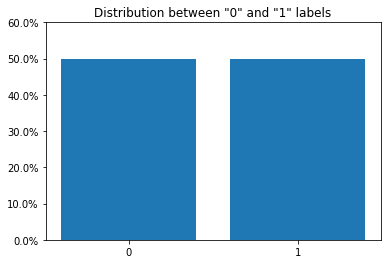

In [11]:
plt.bar([0,1],height=[np.mean((y_np==0)*1),np.mean((y_np==1)*1)])
plt.xticks([0,1])

plt.yticks(np.arange(0,.7,.1,dtype=float), [str(i)+"%" for i in np.arange(0,70,10,dtype=float)])

plt.title('Distribution between "0" and "1" labels')
plt.show()

It seems that the labels are well distributed which will help build a good classifier. We don't need to use resampling methods.

#### Correlation

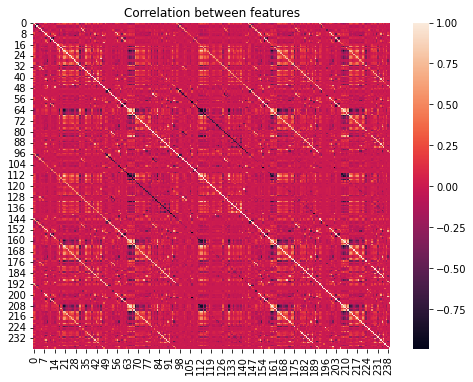

In [309]:
corr_matrix = np.corrcoef(X_np.T)
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix)
plt.title("Correlation between features")
plt.show()

We can see that some of the features are positively and negatively correlated. By adding the features, we added correlation in our dataset. This correlation cannot be avoided and we need the model to understand that the two sets need to be compared so we choose to keep it this way.

# Classification algorithms

In this part, we will introduce the 3 algorithms chosen after multiple trials :
- XGBoost
- CatBoost
- LightGBM

The process is the following :
1. A first trial of the classifier with default hyperparameters (or arbitrary chosen ones) ;
2. An optimization of hyperparameters with a `RandomSearchCV` ;
3. An execution of the optimized classifier.

NB : The `RandomSearchCV` cell outputs won't be displayed as their execution takes a very long time (from 2 to 10 hours)

### Scoring function
$score = 1 - (FPR + FNR)$ with $FNR$ the False Negative Rate and $FPR$ the False Positive Rate.


## XGBoost

The principle of XGBoost is to use gradient boosted trees algorithms, this is an improvment of gradient boosting algorithms. It combines multiple estimators described as weak learners as they work differently and optimize the results by keeping the best of each estimator. For this, this model is known as a very strong and performing algorithm.

XGBoost is also programmed to work in parallel and is hence faster than a classical Gradient Boosting algorithm.

Documentation : 
- https://xgboost.readthedocs.io/en/stable/
- https://xgboost.readthedocs.io/en/stable/parameter.html
- https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/#:~:text=A%20node%20is%20split%20only,function%20and%20should%20be%20tuned.



                                                  XGBoost (first trial) results
Score : 0.6099315
RMSE  : 0.4416328
FPR   : 18.40532%
FPR   : 20.60153%
CPU times: total: 2h 55min 17s
Wall time: 15min 23s


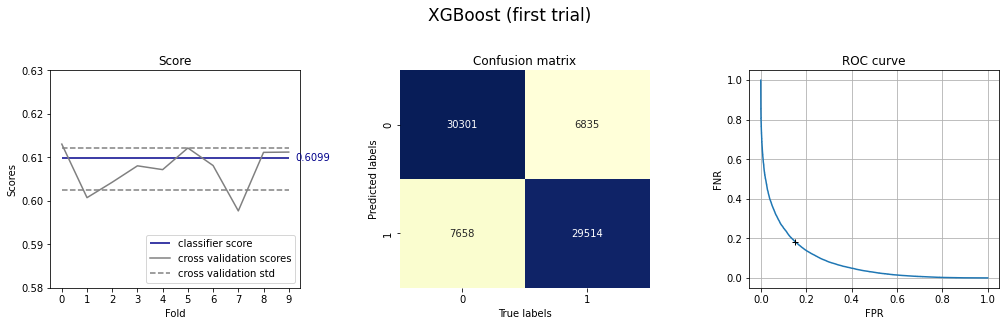

In [284]:
%%time
xgb_model = Classifier("XGBoost (first trial)",XGBClassifier(objective='binary:logistic',eval_metric='logloss',n_jobs=-1))
xgb_model.classify_save_and_score(X_np,y_np,X_test_np,X_train,y_train,X_test,y_test,cross_validation=10,scoring=True)

xgb_model.results()
xgb_model.plot_results()

Then, we use a `RandomSearchCV` to find optimal hyperparameters. We work on :
- `learning_rate` : defines how much the weights will be updated during each iteration
- `n_estimators` : the number of weak learners used
- `max_depth` : the maximum size of the trees (growing too much leads to overfitting)
- `gamma` : the minimum loss reduction required to split a node
- `colsample_bytree` : the fraction of columns to be randomly samples for each tree
- `subsample` : the subsample ratio of columns for each split, in each level

In [ ]:
%%time

folds, comb = 4, 30
# define grid
xgb_param_grid = {
              'learning_rate': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3],
              'n_estimators': [300, 500, 700, 1000, 2000],
              'max_depth': [2,3,4,5,7],
              'gamma': [0, 0.5, 1, 1.5, 2, 5],
              'colsample_bytree': [0.6, 0.8, 1.0],
              'subsample': [0.5, 0.7, 1] 
             }

# run grid search
xgb_clf = XGBClassifier(objective='binary:logistic')
xgb_grid_search = RandomizedSearchCV(estimator=xgb_clf, param_distributions=xgb_param_grid,scoring=make_scorer(compute_score, greater_is_better=True),cv=folds,n_iter=comb)
xgb_grid_search.fit(X_np, y_np)

# print best model
print(xgb_grid_search.best_params_)

                                                  XGBoost (optimized) results
Score : 0.6138054
RMSE  : 0.4394334
FPR   : 18.40801%
FPR   : 20.21145%
CPU times: total: 7h 4min 23s
Wall time: 37min 40s


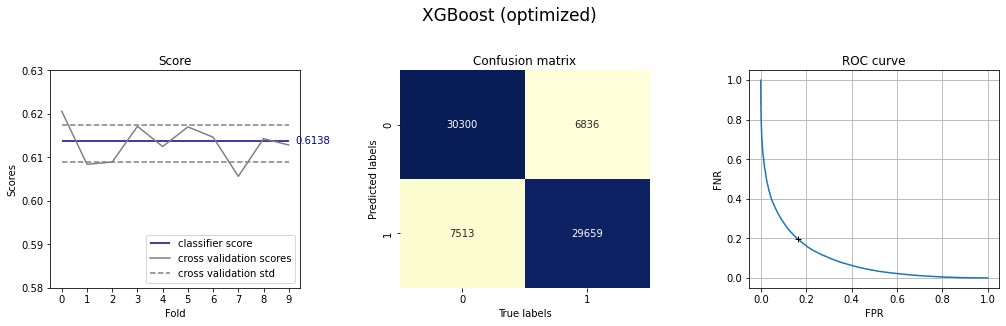

In [248]:
%%time
xgb_clf_opt = XGBClassifier(learning_rate=0.1,
                            n_estimators=500,
                            colsample_bytree=0.8,
                            eval_metric='logloss',
                            gamma=0,
                            max_depth=4,
                            subsample=0.5,
                            n_jobs=12)
              
xgb_model_opt = Classifier("XGBoost (optimized)",xgb_clf_opt)
xgb_model_opt.classify_save_and_score(X_np,y_np,X_test_np,X_train,y_train,X_test,y_test, cross_validation=10,scoring=True)

xgb_model_opt.results()
xgb_model_opt.plot_results()

### XGBoost summary

                                                  XGBoost (first trial) results
Score : 0.6099315
RMSE  : 0.4416328
FPR   : 18.40532%
FPR   : 20.60153%
                                                  XGBoost (optimized) results
Score : 0.6138054
RMSE  : 0.4394334
FPR   : 18.40801%
FPR   : 20.21145%
===> Score improvement : +0.0039


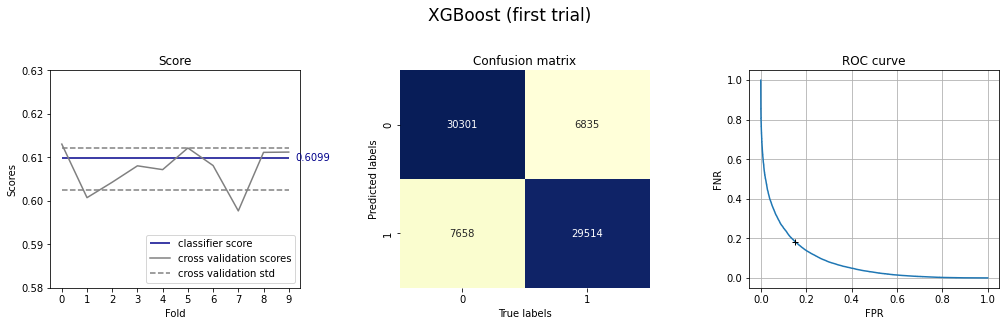

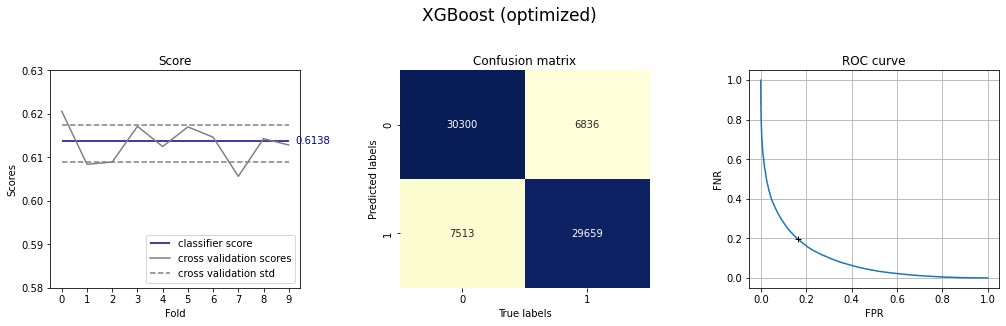

In [299]:
xgb_model.results()
xgb_model.plot_results()
xgb_model_opt.results()
xgb_model_opt.plot_results()
print (f"===> Score improvement : {xgb_model_opt.score-xgb_model.score:+.4f}")

By optimizing the hyperparameters we obtain a better classifier :
- a **+0.0039 score improvement**
- a **lower variability** of the model : the cross validation curve is less variable and the RMSE decreased
- a **better fit** : the cross validation curve is closer to the score


### CatBoost

CatBoost is a is also a variant of gradient boosting on decision trees. The key features of this algorithm are :
- **Symmetric trees** (unlike XGBoost) : aids in efficient CPU implementation, decreases prediction time, makes swift model appliers, and controls overfitting as the structure serves as regularization
- **Ordered boosting** : training the model on a subset of data while calculating residuals on another subset, thus preventing target leakage and overfitting
- **Feature support** : allows categorical features (unlike XGBoost)

Documentation :
- https://catboost.ai/

                                                  CatBoost (first trial) results
Score : 0.6197289
RMSE  : 0.4360516
FPR   : 17.87753%
FPR   : 20.14957%
CPU times: total: 4h 57min 5s
Wall time: 30min 35s


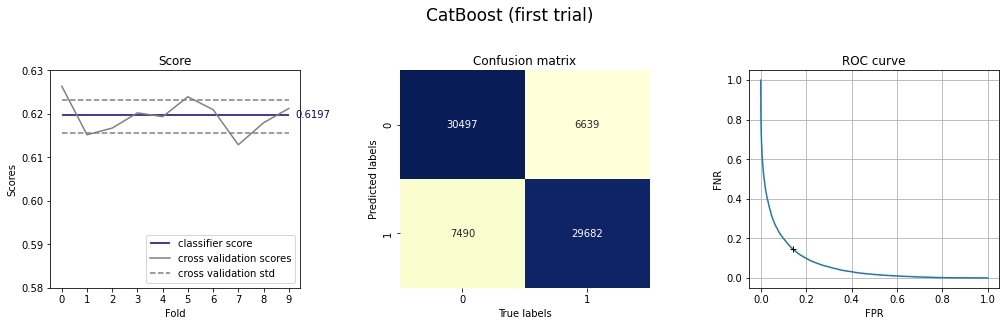

In [249]:
%%time
catb_clf=CatBoostClassifier(iterations=2000, learning_rate=0.1, loss_function='Logloss', eval_metric = 'F1', logging_level='Silent')
catb_model = Classifier("CatBoost (first trial)", catb_clf)
catb_model.classify_save_and_score(X_np,y_np,X_test_np,X_train,y_train,X_test,y_test,cross_validation=10,scoring=True)

catb_model.results()
catb_model.plot_results()

Then, we use a `RandomSearchCV` to find optimal parameters. We work on :
- `depth` : depth of the trees
- `iterations` : number of trees built
- `learning_rate` : defines how much the weights will be updated during each iteration
- `l2_leaf_reg` : coefficient of the L2 (ridge) regularization term of the cost function
- `border_count` : number of splits for numerical features
- `loss_function` : metric to use in training

In [ ]:
%%time
folds, comb = 4, 1

catb_param_grid = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[1500, 1700, 2000, 2200],
          'learning_rate':[0.01,0.09,0.1,0.11, 0.12, 0.2,0.3],
          'l2_leaf_reg':[3,1,5,10,100,150,200],
          'border_count':[10,20,50,100,150,200],
          'loss_function': ['Logloss', 'CrossEntropy']}


catb_clf = CatBoostClassifier(verbose=False)
catb_grid_search = RandomizedSearchCV(estimator=catb_clf, param_distributions=catb_param_grid,scoring=make_scorer(compute_score, greater_is_better=True),cv=folds,n_iter=comb)
catb_grid_search.fit(X_np, y_np)


print(catb_grid_search.best_params_)


                                                  CatBoost (optimized) results
Score : 0.6213449
RMSE  : 0.4351248
FPR   : 17.69173%
FPR   : 20.17379%
CPU times: total: 11h 47min 32s
Wall time: 1h 9min 20s


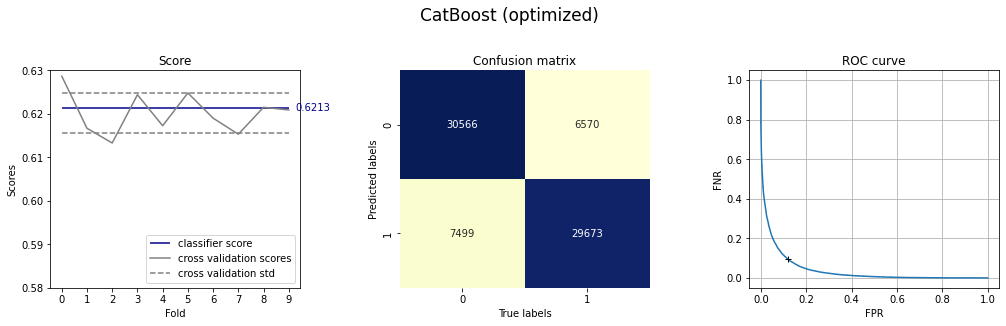

In [250]:
%%time
catb_clf_opt = CatBoostClassifier(iterations= 2000,
                                learning_rate= 0.1,
                                depth= 9,
                                l2_leaf_reg= 100,
                                loss_function= 'CrossEntropy',
                                border_count= 200,
                                logging_level='Silent',
                                eval_metric= 'F1')
                                
catb_model_opt = Classifier("CatBoost (optimized)",catb_clf_opt)
catb_model_opt.classify_save_and_score(X_np,y_np,X_test_np,X_train,y_train,X_test,y_test, cross_validation=10, scoring=True)

catb_model_opt.results()
catb_model_opt.plot_results()

### CatBoost Summary

                                                  CatBoost (first trial) results
Score : 0.6197289
RMSE  : 0.4360516
FPR   : 17.87753%
FPR   : 20.14957%
                                                  CatBoost (optimized) results
Score : 0.6213449
RMSE  : 0.4351248
FPR   : 17.69173%
FPR   : 20.17379%
===> Score improvement : +0.0016


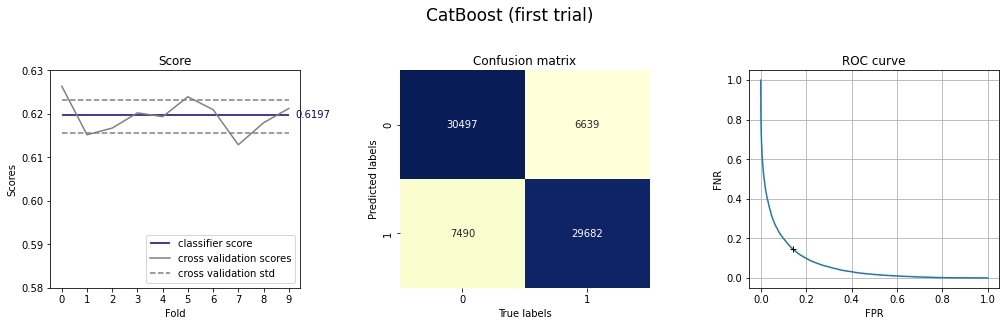

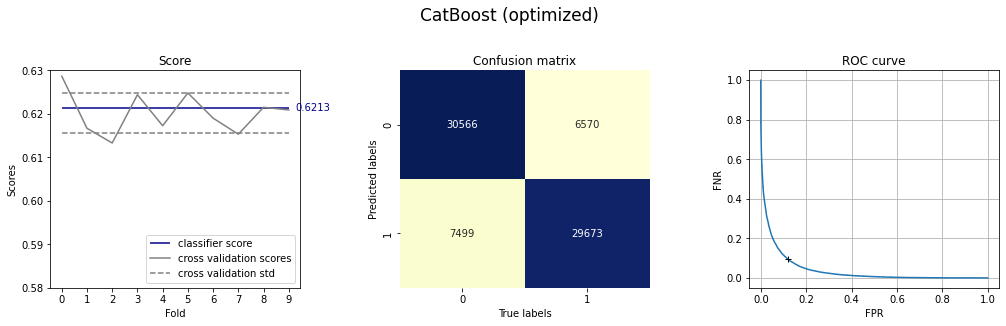

In [300]:
catb_model.results()
catb_model.plot_results()
catb_model_opt.results()
catb_model_opt.plot_results()
print (f"===> Score improvement : {catb_model_opt.score-catb_model.score:+.4f}")

By optimizing the hyperparameters we obtain a better classifier :
- a **+0.0016 score improvement**
- a **slightly lower variability** of the model : the RMSE decreased a bit
- a **similar fit** : the cross validation curve is close to the score for both models

### LightGBM

LightGBM is a free and open source distributed gradient boosting framework for machine learning originally developed by Microsoft. It is also based on decision trees. Its development is based in increasing execution time and performance.
In contrast to the level-wise (horizontal) growth in XGBoost, LightGBM carries out leaf-wise (vertical) growth that results in more loss reduction and in turn higher accuracy while being faster. But this may also result in overfitting on the training data which could be handled using the max-depth parameter that specifies where the splitting would occur. Hence, XGBoost is capable of building more robust models than LightGBM.

Documentation :
- https://lightgbm.readthedocs.io/en/latest/
- https://www.kaggle.com/code/prashant111/lightgbm-classifier-in-python/notebook

                                                  LightGBM (first trial) results
Score : 0.6110409
RMSE  : 0.4410077
FPR   : 17.74828%
FPR   : 21.14764%
CPU times: total: 18min 41s
Wall time: 2min 8s


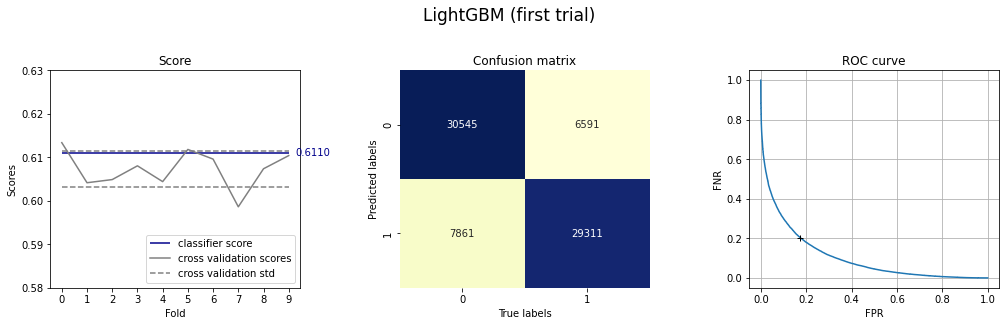

In [9]:
%%time
lgbm_clf=LGBMClassifier(n_jobs=-1,objective='binary')
lgbm_model = Classifier("LightGBM (first trial)", lgbm_clf)
lgbm_model.classify_save_and_score(X_np,y_np,X_test_np,X_train,y_train,X_test,y_test,cross_validation=10,scoring=True)

lgbm_model.results()
lgbm_model.plot_results()

Then, we use a `RandomSearchCV` to find optimal parameters. We work on :
- `num_leaves` :
- `learning_rate` : defines how much the weights will be updated during each iteration
- `n_estimators` : the number of weak learners used
- `max_depth` : the maximum size of the trees (growing too much leads to overfitting)
- `subsample` : the subsample ratio of columns for each split, in each level
- `colsample_bytree` : the fraction of columns to be randomly samples for each tree

In [ ]:
%%time
folds, comb = 4, 60

# define grid
lgbm_param_grid = {'num_leaves': [7, 14, 21, 28, 31, 50, 100, 200],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3, 0.35, 0.4],
          'n_estimators': [300, 500, 700, 1000, 1500, 2000],
          'max_depth': [2,3,4,5,7,10,20,50,100],
          'subsample': [0.5, 0.7, 0.8, 0.9, 1],
          'colsample_bytree':[0.5, 0.6, 0.7, 0.8]}

# run grid search
lgbm_clf = LGBMClassifier(n_jobs=-1,objective='binary')
lgbm_grid_search = RandomizedSearchCV(estimator=lgbm_clf, param_distributions=lgbm_param_grid,scoring=make_scorer(compute_score, greater_is_better=True),cv=folds,n_iter=comb)
lgbm_grid_search.fit(X_np, y_np)

print(lgbm_grid_search.best_params_)

                                                  LightGBM (optimized) results
Score : 0.6232594
RMSE  : 0.4340255
FPR   : 17.23126%
FPR   : 20.44281%
CPU times: total: 3h 49min 27s
Wall time: 21min 55s


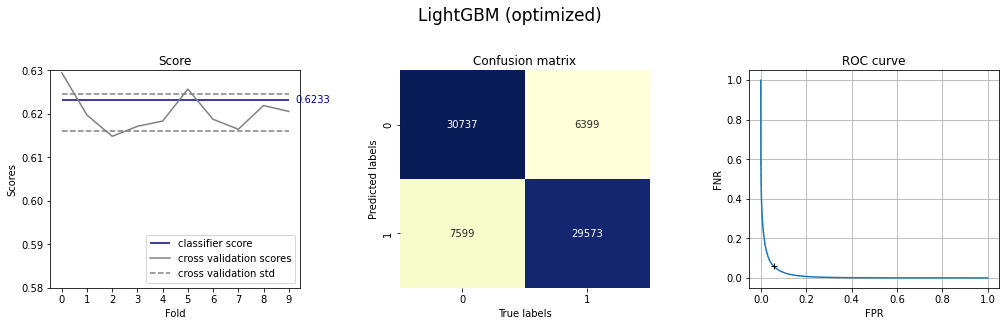

In [253]:
%%time
lgbm_clf_opt = LGBMClassifier(colsample_bytree=0.5, learning_rate=0.03, max_depth=10,
               n_estimators=1700, num_leaves=200, objective='binary',
               subsample=1)
                            
lgbm_model_opt = Classifier("LightGBM (optimized)",lgbm_clf_opt)
lgbm_model_opt.classify_save_and_score(X_np,y_np,X_test_np,X_train,y_train,X_test,y_test,cross_validation=10,scoring=True)

lgbm_model_opt.results()
lgbm_model_opt.plot_results()

### LightGBM Summary

                                                  LightGBM (first trial) results
Score : 0.6110409
RMSE  : 0.4410077
FPR   : 17.74828%
FPR   : 21.14764%
                                                  LightGBM (optimized) results
Score : 0.6232594
RMSE  : 0.4340255
FPR   : 17.23126%
FPR   : 20.44281%
===> Score improvement : +0.0122


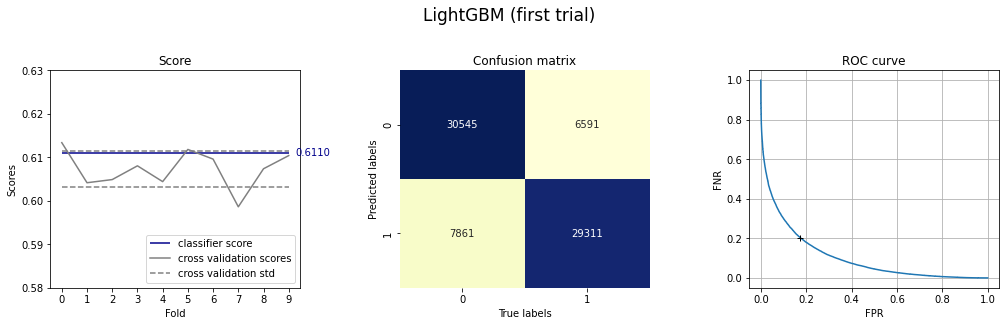

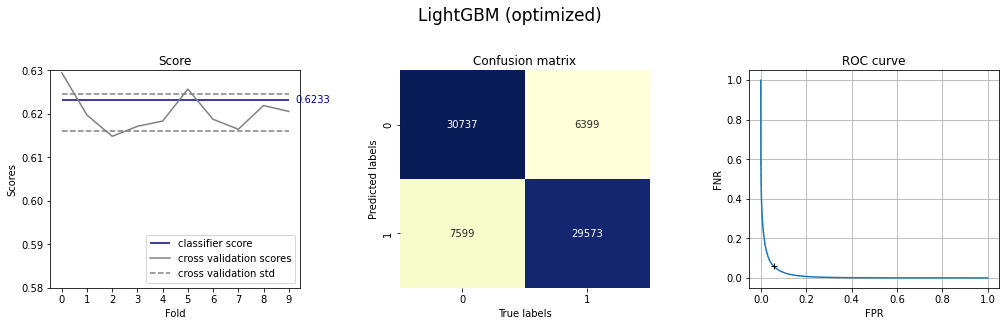

In [302]:
lgbm_model.results()
lgbm_model.plot_results()
lgbm_model_opt.results()
lgbm_model_opt.plot_results()
print (f"===> Score improvement : {lgbm_model_opt.score-lgbm_model.score:+.4f}")

By optimizing the hyperparameters, we obtain a much better classifier :
- a **+0.0122 score improvement** that shows a great potentential for this classifier. The increase is almost 10 times the improvement we had by optimizing XGBoost and CatBoost 
- a **lower variability** of the model : the RMSE decreased significantly and the cross validation curve shows less peaks and variations
- a **better fit** : the cross validation curve is closer to the score

## Optimal classifiers summary

                                                  XGBoost (optimized) results
Score : 0.6138054
RMSE  : 0.4394334
FPR   : 18.40801%
FPR   : 20.21145%
                                                  CatBoost (optimized) results
Score : 0.6213449
RMSE  : 0.4351248
FPR   : 17.69173%
FPR   : 20.17379%
                                                  LightGBM (optimized) results
Score : 0.6232594
RMSE  : 0.4340255
FPR   : 17.23126%
FPR   : 20.44281%


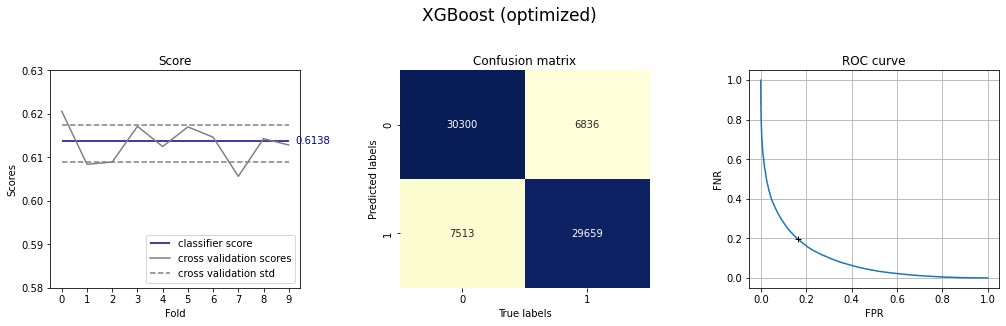

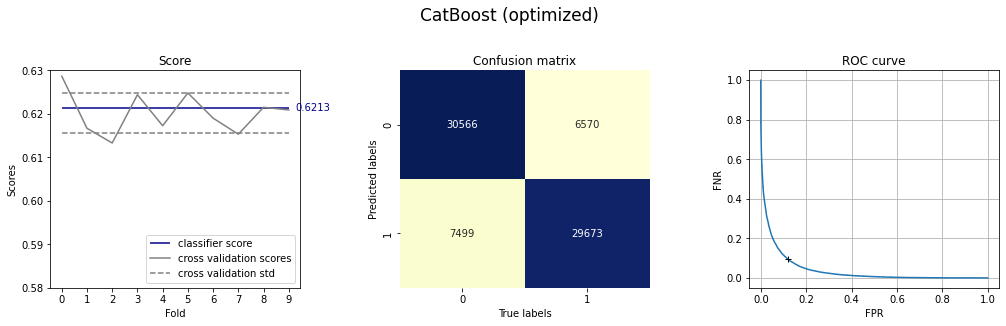

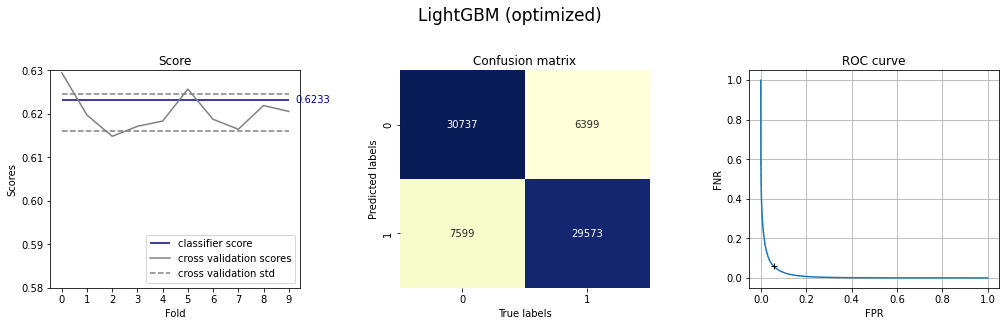

In [303]:
xgb_model_opt.results()
catb_model_opt.results()
lgbm_model_opt.results()

xgb_model_opt.plot_results()
catb_model_opt.plot_results()
lgbm_model_opt.plot_results()

Let's analyze our three models :
- **Fitting** : the three models do not seem to overfit, as the cross validation curve is very close to the score 
- **Score performance** : LightGBM seems to work better than CatBoost, and much better than XGBoost. 
- **Confusion matrix** : again, the same hierachy shows, LightGBM makes better prediction
- **ROC Curve** : LightGBM seems again to be the best classifier of the three. Its ROC curve is close to perfect. CatBoost ROC curve shows also good performances, and XGBoost is behind
- **Variability** : looking at the RMSE, LightGBM shows less variability in the prediction, followed by CatBoost and then XGBoost

## Voting
Now that we are 3 good classifiers, we can combine them to optimize our prediction. The voting classifier aggregates the predicted class on basis of hard voting or soft voting.

A **hard voting** ensemble involves that the predicted target label of the ensemble is the mode of the distribution of individually predicted labels (the majority wins)

A **soft voting** ensemble involves that the predictions are weighted by the classifier's importance and summed up.

We will try them both.

                                                  Hard voting on XGBoost - CatBoost - LightGBM results
Score : 0.6238224
RMSE  : 0.4336998
FPR   : 17.43053%
FPR   : 20.18724%
CPU times: total: 23h 1min 29s
Wall time: 2h 20min 1s


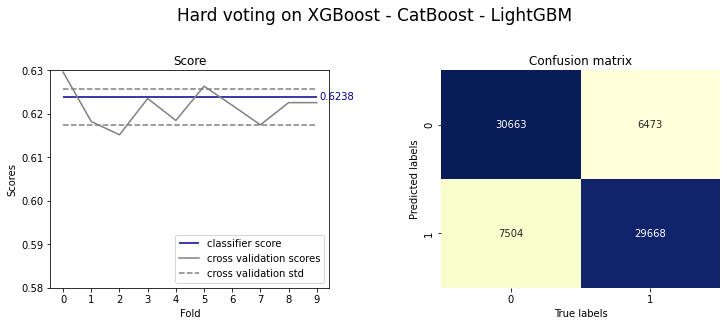

In [305]:
%%time

estimators = [('xgb', xgb_clf_opt),
              ('catb', catb_clf_opt),
              ('lgbm',lgbm_clf_opt)]

hard_voting_clf = VotingClassifier(estimators=estimators, voting='hard')

hard_voting_model = Classifier("Hard voting on XGBoost - CatBoost - LightGBM",hard_voting_clf)
hard_voting_model.classify_save_and_score(X_np,y_np,X_test_np,X_train,y_train,X_test,y_test,cross_validation=10,scoring=True)

hard_voting_model.results()
hard_voting_model.plot_results(plots=2)

Hard voting on the three models shows a small improvement in performance compared to the best score we obtained with LightGBM (0.6238 vs. 0.6233).

We will now try soft voting to see if the performance can be pushed even higher. By giving more weight to better performing models, we hope to increase the result of the vote.

We give 20% to XGBoost, 30% to CatBoost and 50% to LightGBM.

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

                                                  Weighted Voting (XGBoost 0.1 - CatBoost 0.3 - LightGBM 0.6) results
Score : 0.6232594
RMSE  : 0.4340255
FPR   : 17.23126%
FPR   : 20.44281%
CPU times: total: 22h 49min 25s
Wall time: 2h 10min 58s


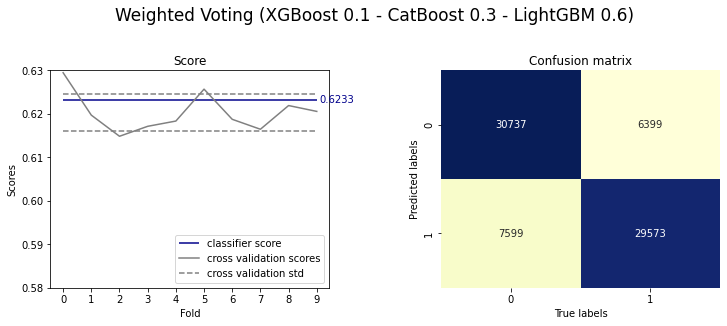

In [282]:
%%time

estimators = [('xgb', xgb_clf_opt),
              ('catb', catb_clf_opt),
              ('lgbm',lgbm_clf_opt)]

weighted_voting_clf = VotingClassifier(estimators=estimators, weights=[0.2,0.3,0.5])

weighted_voting_model = Classifier("Weighted Voting (XGBoost 0.1 - CatBoost 0.3 - LightGBM 0.6)",weighted_voting_clf)
weighted_voting_model.classify_save_and_score(X_np,y_np,X_test_np,X_train,y_train,X_test,y_test,cross_validation=10,scoring=True)

weighted_voting_model.results()
weighted_voting_model.plot_results(plots=2)

The results are the same as LightGBM alone. It seems thats LightGBM took over in the voting model. 
Since we did not obtain better performances than LightGBM alone, we try to exclude XGBoost, as it is the least performing algorithm among the three.

We give a weight of 70% to LightGBM and 30% to CatBoost.

                                                  Weighted voting (CatBoost 0.3 - LightGBM 0.7) results
Score : 0.6254126
RMSE  : 0.4327834
FPR   : 17.12355%
FPR   : 20.33520%
CPU times: total: 15h 13min 55s
Wall time: 1h 28min 40s


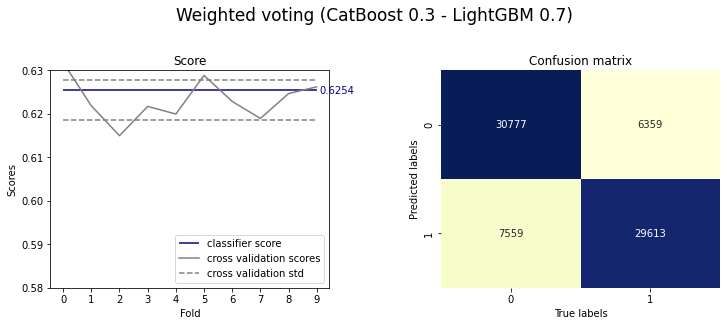

In [306]:
%%time

estimators = [('catb', catb_clf_opt),
              ('lgbm',lgbm_clf_opt)]

cat_lgb_voting_clf = VotingClassifier(estimators=estimators, voting='soft', weights=[0.3,0.7])

cat_lgb_voting_model = Classifier("Weighted voting (CatBoost 0.3 - LightGBM 0.7)",cat_lgb_voting_clf)
cat_lgb_voting_model.classify_save_and_score(X_np,y_np,X_test_np,X_train,y_train,X_test,y_test,cross_validation=10,scoring=True)

cat_lgb_voting_model.results()
cat_lgb_voting_model.plot_results(plots=2)

## Voting Summary

                                                  Hard voting on XGBoost - CatBoost - LightGBM results
Score : 0.6238224
RMSE  : 0.4336998
FPR   : 17.43053%
FPR   : 20.18724%
                                                  Weighted Voting (XGBoost 0.1 - CatBoost 0.3 - LightGBM 0.6) results
Score : 0.6232594
RMSE  : 0.4340255
FPR   : 17.23126%
FPR   : 20.44281%
                                                  Weighted voting (CatBoost 0.3 - LightGBM 0.7) results
Score : 0.6254126
RMSE  : 0.4327834
FPR   : 17.12355%
FPR   : 20.33520%


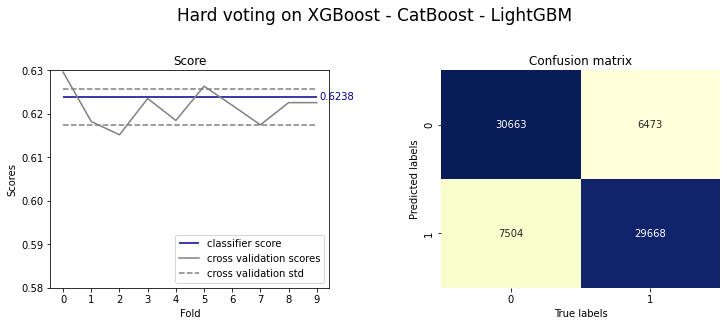

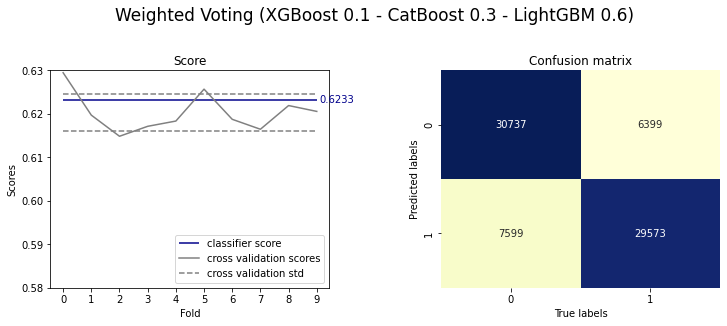

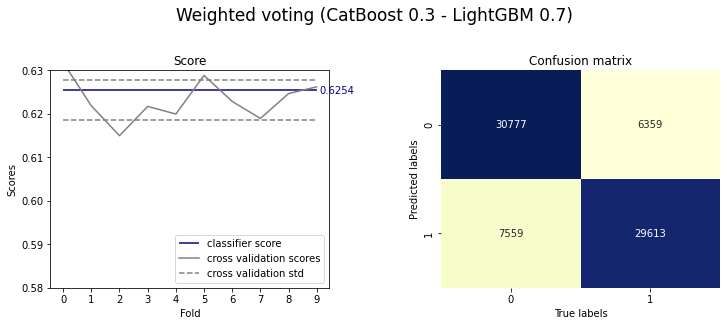

In [310]:
hard_voting_model.results()
weighted_voting_model.results()
cat_lgb_voting_model.results()

hard_voting_model.plot_results(plots=2)
weighted_voting_model.plot_results(plots=2)
cat_lgb_voting_model.plot_results(plots=2)

Removing the XGBoost has been very beneficial : we can see the score highly improving and the varability decreasing in the same time. We keep this classifier as the best one tried so far in this challenge. 

# Conclusion

**What I learned**

This data challenge was a great lesson to understand the challenges of machine learning. It helped me get familiar with a great number of classifiers, with the scientific approach for solving a given machin learning problem, and helped me to understand the importance of each step. 

**Problems encountered**

During the process, execution times were the main issue. The step of searching for the best hyperparameters was the most greedy. It requires a good computing power in order to be able to benefit from the parallelized framework offered by the algortihms tried (or a lot of patience).

Also, the wide variety of classifiers (some of them were also requiring a good computing power) made it difficult to know which ones to try and which ones not to.

**What could have been done to go further**

As the execution times limited my ability to perfectly tune the algorithms, more time would have helped to tweak even more the hyperparamters and get even better performances. 

It could have been also great to try other ensemble methods such as bagging or stacking, or implement a neural network to solve the problem and compare the performance between machine and deep learning algorithms.
